# Model Contribution Tutorial

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/BigDataWUR/AgML-crop-yield-forecasting/blob/krsnapaudel-python-package/examples/model_contribution.ipynb)

## Comet setup

### Package installation

In [ ]:
!pip install comet_ml >/dev/null

### Experiment setup

In [ ]:
import comet_ml

experiment = comet_ml.Experiment(
    api_key=<api_key>,
    project_name="agml-workshop",
)

## Utility functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklean.metrics import mean_squared_error

def normalized_rmse(y_true, y_pred):
    return 100 * np.sqrt(mean_squared_error(y_true, y_pred)) / np.mean(y_true)

def plotStaticMaps(pd_data_df, sel_years,
                   geo_state_df,
                   map_limits,
                   show_col, fig_title,
                   vmin, vmax):
  """Plot static yield maps per year"""
  num_plots = len(sel_years)
  fig, axs = plt.subplots(1, num_plots, figsize=((num_plots * 10), 8))
  for i, yr in enumerate(sel_years):
    year_yields = pd_data_df[pd_data_df['FYEAR'] == yr]
    color_map = 'RdYlBu'
    sel_ax = axs if (num_plots == 1) else axs[i]
    sel_ax.set_xlim(map_limits['xmin'], map_limits['xmax'])
    sel_ax.set_ylim(map_limits['ymin'], map_limits['ymax'])
    sel_ax.set_title(yr)
    sel_ax.set_facecolor("white")
    base = year_yields.plot(column=show_col, ax=sel_ax,
                            linewidth=1.0, edgecolor='white',
                            legend=(i==0),
                            cmap=color_map, vmax=vmax, vmin=vmin)
    state_ax = geo_state_df.plot(ax=base, edgecolor='gray', linewidth=1.5, facecolor="none")
    base.set(yticklabels=[])
    base.set(xticklabels=[])

    fig.suptitle(fig_title, fontsize=18, fontweight='bold')

def plotHistograms(train_df, test_df, show_col):
  fig, axs = plt.subplots(1, 2, figsize=((2 * 8), 8))
  vmin = int(min(train_df[show_col].min(), test_df[show_col].min()))
  vmax = int(max(train_df[show_col].max(), test_df[show_col].max())) + 1

  _ = axs[0].hist(train_df[show_col], range(vmin, vmax))
  _ = axs[0].set_title("Training " + show_col)
  _ = axs[1].hist(test_df[show_col], range(vmin, vmax))
  _ = axs[1].set_title("Test " + show_col)

def scatterPlots(test_preds, sel_years, sel_colors, label_col, year_col):
    num_algs = len(test_preds)
    num_plots = 3
    num_rows = int(num_algs/num_plots)
    if (num_algs % num_plots) > 0:
        num_rows += 1

    fig, axs = plt.subplots(num_rows, num_plots, figsize=((num_plots * 6), (num_rows * 6)))
    for i, alg_name in enumerate(list(test_preds.keys())):
        alg_preds = test_preds[alg_name]
        sel_ax = axs[int(i/num_plots)][i % num_plots]
        for j, yr in enumerate(sel_years):
            year_preds = alg_preds[alg_preds[year_col] == yr]
            # sel_ax = axs if (num_algs == 1) else axs[i*num_rows + j]
            sel_ax.scatter(year_preds[label_col].values, year_preds["PREDICTION"].values, color=sel_colors[j])
            sel_ax.set_title(alg_name)
            sel_ax.legend(sel_years)

def getMetrics(model_preds, test_years, label_col, year_col):
    metrics = {}
    for yr in test_years:
        year_preds = model_preds[model_preds[year_col] == yr]
        nrmse = normalized_rmse(
          year_preds[label_col].values, year_preds["PREDICTION"].values
        )
        r2 = r2_score(year_preds[label_col].values, year_preds["PREDICTION"].values)
        metrics["NRMSE " + str(yr)] = nrmse
        metrics["R2 " + str(yr)] = r2

    # overall metrics
    nrmse = normalized_rmse(
        model_preds[label_col].values, model_preds["PREDICTION"].values
    )
    r2 = r2_score(model_preds[label_col].values, model_preds["PREDICTION"].values)
    metrics["NRMSE (Overall)"] = nrmse
    metrics["R2 (Overall)"] = r2

    return metrics

def evaluatePredictions(test_preds, label_col, year_col):
    performance_data = []
    data_cols = None
    for model_name in test_preds:
        print("\n")
        print("Predictions of ", model_name)
        model_preds = test_preds[model_name]
        print(model_preds.head(5).to_string())
        test_years = sorted(model_preds[year_col].unique())
        model_metrics = getMetrics(model_preds, test_years, label_col, year_col)
        data_item = [model_name]
        if (data_cols is None):
          data_cols = ["Model"] + list(model_metrics.keys())

        for met in data_cols[1:]:
          data_item.append(model_metrics[met])

        performance_data.append(data_item)

    performance_df = pd.DataFrame(performance_data, columns=data_cols)
    print("\n")
    print(performance_df.head(10).to_string())

## Clone repository

In [ ]:
! rm -rf AgML-crop-yield-forecasting/
! git clone --branch krsnapaudel-python-package https://github.com/BigDataWUR/AgML-crop-yield-forecasting.git

Cloning into 'AgML-crop-yield-forecasting'...
remote: Enumerating objects: 432, done.
remote: Counting objects: 100% (235/235), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 432 (delta 120), reused 162 (delta 79), pack-reused 197
Receiving objects: 100% (432/432), 1.37 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (205/205), done.


## Add repository to path

In [ ]:
import sys
sys.path.append('/content/AgML-crop-yield-forecasting')

## Get data from GitHub

In [ ]:
! rm -rf AgML-crop-yield-forecasting/data
! git clone https://github.com/BigDataWUR/sample_data.git AgML-crop-yield-forecasting/data

Cloning into 'AgML-crop-yield-forecasting/data'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 31 (delta 3), reused 12 (delta 2), pack-reused 16
Receiving objects: 100% (31/31), 40.89 MiB | 10.85 MiB/s, done.
Resolving deltas: 100% (5/5), done.
Updating files: 100% (10/10), done.


## Data

### Overview

Yield data for corn (or grain maize) in the US until 2018.
When aligning with other data (including remote sensing), data is available from 2000 to 2018. However, the data is not spatially (by county) or temporally (by year) complete.

**Training set**: 2000-2011, 2013-2017

**Test set**: 2012 (extreme harvest due to drought), 2018 (the last available year)

Predictor data: described in **Raw data** below.

#### Get shapefiles

In [ ]:
! wget https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip

--2024-01-16 12:50:43--  https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip
Resolving www2.census.gov (www2.census.gov)... 92.123.200.196, 2600:1409:12:286::208c, 2600:1409:12:28d::208c
Connecting to www2.census.gov (www2.census.gov)|92.123.200.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2018_us_county_500k.zip’

cb_2018_us_county_5     [         <=>        ]  11.00M   889KB/s    in 13s     

2024-01-16 12:50:56 (884 KB/s) - ‘cb_2018_us_county_500k.zip’ saved [11530479]



In [ ]:
! wget https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip

--2024-01-16 12:51:31--  https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip
Resolving www2.census.gov (www2.census.gov)... 23.37.221.71, 2600:1409:12:286::208c, 2600:1409:12:28d::208c
Connecting to www2.census.gov (www2.census.gov)|23.37.221.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘cb_2018_us_state_500k.zip’

cb_2018_us_state_50     [ <=>                ]   3.15M  --.-KB/s    in 0.07s   

2024-01-16 12:51:32 (42.6 MB/s) - ‘cb_2018_us_state_500k.zip’ saved [3304931]



#### Spatial variability in test years

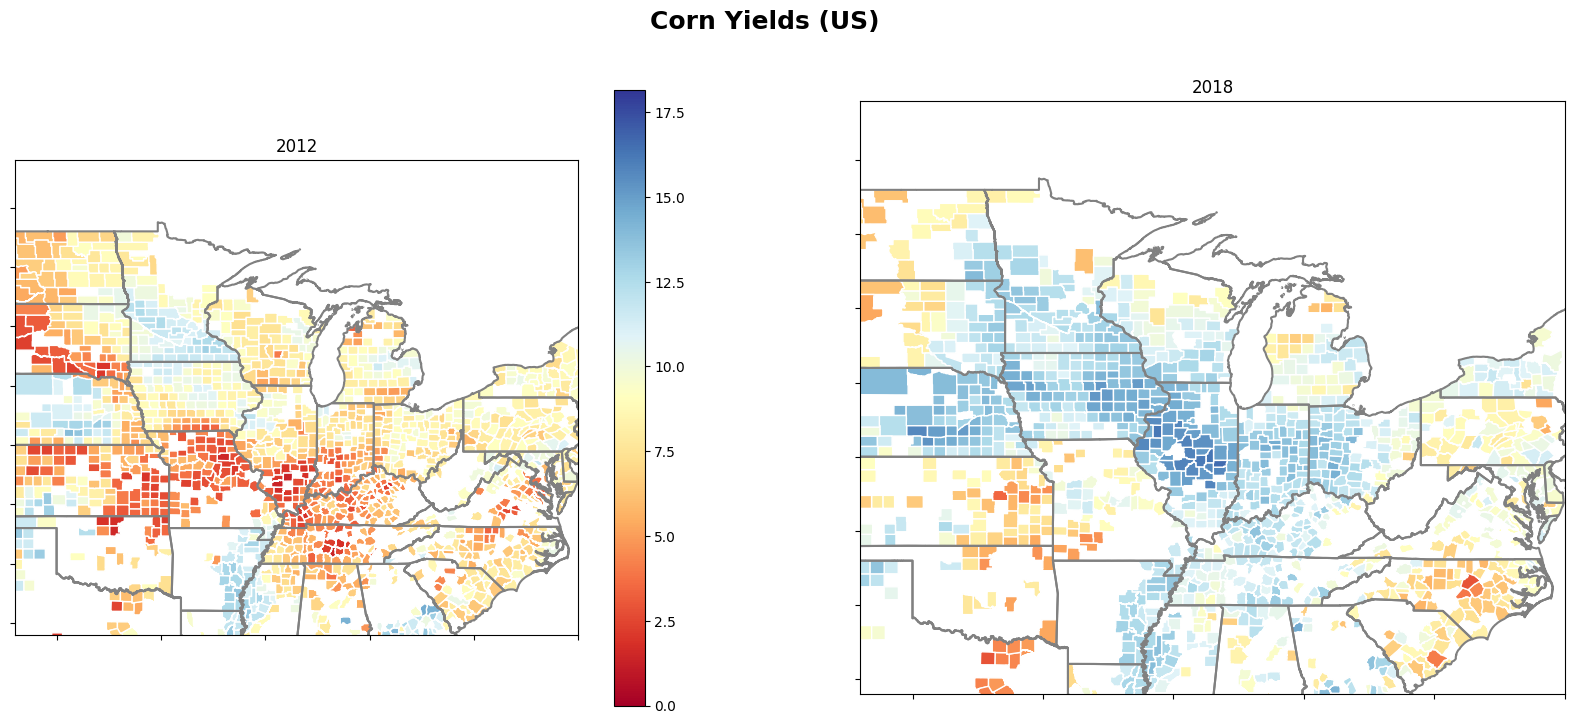

In [ ]:
import pandas as pd
import geopandas as gpd
import os
import matplotlib.pyplot as plt

from config import PATH_DATA_DIR

zipfile_states = "cb_2018_us_state_500k.zip"
zipfile_counties = "cb_2018_us_county_500k.zip"

geo_state_df = gpd.read_file(zipfile_states)
geo_state_df = geo_state_df.rename(columns={'NAME' : 'STATE_NAME',
                                               'STUSPS' : 'STATE_CODE'})
geo_state_df['STATE_NAME'] = geo_state_df['STATE_NAME'].str.upper()

geo_county_df = gpd.read_file(zipfile_counties)
geo_county_df = geo_county_df.rename(columns={'NAME' : 'COUNTY_NAME'})
geo_county_df['COUNTY_NAME'] = geo_county_df['COUNTY_NAME'].str.upper()
geo_county_df = geo_county_df.merge(geo_state_df[['STATEFP', 'STATE_NAME', 'STATE_CODE']], on=['STATEFP'])
geo_county_df['COUNTY_ID'] = geo_county_df['STATE_CODE'] + '_' + geo_county_df['COUNTY_NAME'].str.replace(' ', '_')

data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_data")
yield_csv = os.path.join(data_path, "YIELD_COUNTY_US.csv")
yield_df = pd.read_csv(yield_csv, header=0)
# print(yield_df.head(5))
geo_yield_df = geo_county_df.merge(yield_df, on=["COUNTY_ID"])
# print(geo_yield_df.head(5))

map_limits = {
    'xmin' : -102, 'xmax' : -75,
    'ymin' : 32, 'ymax' : 52,
}

fig_title = 'Corn Yields (US)'

sel_years = [2012, 2018]
vmin = yield_df["YIELD"].min()
vmax = yield_df["YIELD"].max()
plotStaticMaps(geo_yield_df, sel_years,
               geo_state_df, map_limits,
               "YIELD", fig_title,
               vmin, vmax)

#### Training and Test distributions

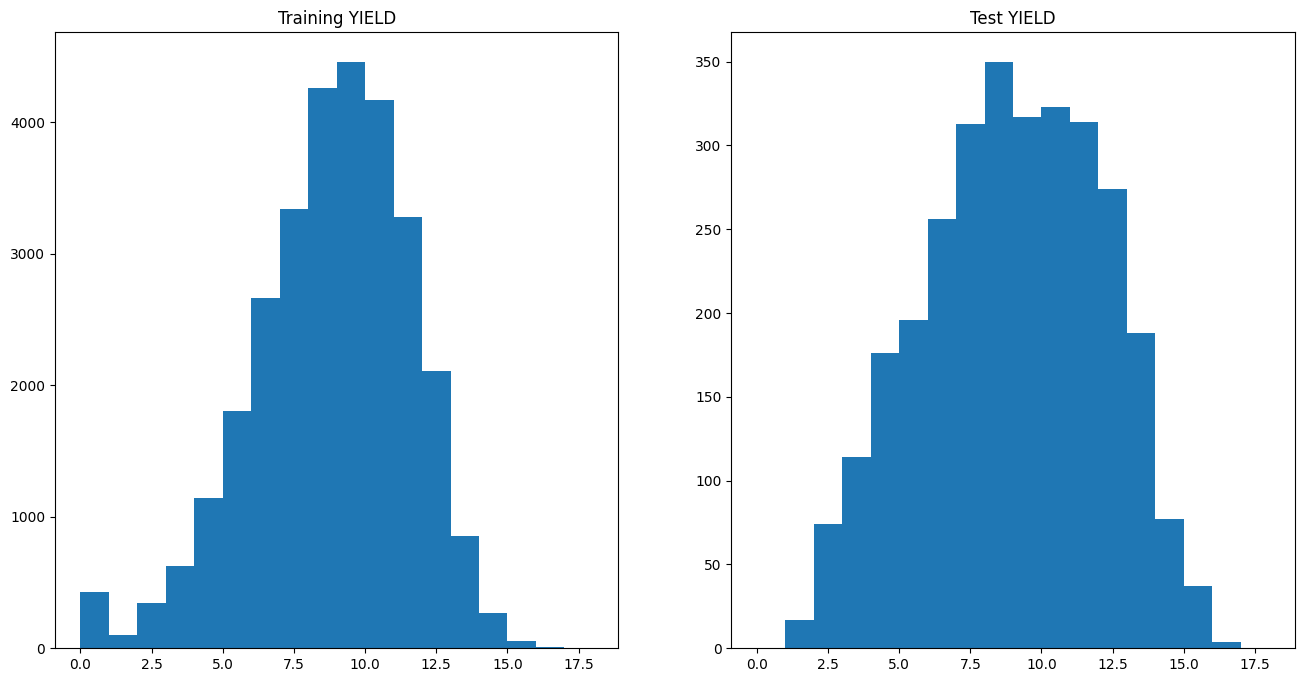

In [ ]:
test_years = [2012, 2018]
train_years = [yr for yr in range(2000, 2019) if yr not in test_years]
train_yields = yield_df[yield_df["FYEAR"].isin(train_years)]
test_yields = yield_df[yield_df["FYEAR"].isin(test_years)]

plotHistograms(train_yields, test_yields, "YIELD")

### Raw data

The data includes predictors:
* Weather data from [AgERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.6c68c9bb?tab=overview): Maximum Temperature, Minimum Temperature, Average Temperature, Vapor Pressure, Wind Speed, Precipitation, Potential Evapotranspiration (from [a different source](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agroproductivity-indicators?tab=overview)), Radiation.
* Remote sensing data from [Copernicus Global Land Service](https://land.copernicus.eu/global/products/fapar): Fraction of absorbed photosynthetically active radiation (FAPAR).
* Soil data from [WISE soil database](https://data.isric.org/geonetwork/srv/eng/catalog.search#/metadata/dc7b283a-8f19-45e1-aaed-e9bd515119bc): soil water holding capacity.


### Feature data

**Crop calendar**

The crop calendar is based on development stage simulated with [a simple light-use efficiency based model](https://cds.climate.copernicus.eu/cdsapp#!/dataset/sis-agroproductivity-indicators?tab=overview).

| DVS value | Crop Calendar Period |
|:----------|:---------------------|
| until DVSgt0  | Pre-planting |
| one dekad before DVSgt0 to one dekad after DVSgt0 | Emergence |
| DVSgt0 to DVSgt1  | Vegetative |
| one dekad before DVSgt1 to one dekad after DVSgt1 | Flowering |
| DVSgt1 to DVSgt2  | Yield formation |
| one dekad before DVSgt2 to one dekad after DVSgt2 | Maturity |

These are the same crop calendar periods from [Paudel et al, 2021](https://doi.org/10.1016/j.agsy.2020.103016), Table 1. Feature design uses the following table, loosely based on [Paudel et al, 2022](https://doi.org/10.1016/j.fcr.2021.108377), Table A.5.

| Period | Average values | zscores (stds above or below avg) |
|:-------|:---------------|-----------------------------------|
| Pre-planting | TAVG, CWB, PREC | |
| Emergence | TAVG, PREC | TAVG, TMIN, PREC |
| Vegetative | TAVG, CWB, FAPAR | |
| Flowering | TAVG, PREC | TAVG, CWB, PREC, TMAX |
| Yield formation | CWB, FAPAR | |
| Maturity | PREC | PREC |

**Notes**:
* CWB = Precipitation - Potential Evapotraspiration (it's accumulated over the season).
* Soil water holding capacity used directly as a feature.
* Crop model outputs and yield trend features have been removed when preparing data for this workshop.

## Existing models

**Naive models**
* RandomYieldModel: Random value between min and max yields from the training data.
* AverageYieldModel: Average of the county from the training data.

**Trend models**
* LinearTrendModel: Linear fit of yields from five previous (available) years.

**Scikit-learn models**
* RidgeModel: Linear model with some regularization.

**PyTorch Neural Network models**
* LSTMModel: Simple LSTM layer followed by a linear layer.

### Create directory to save models

In [ ]:
! mkdir -p AgML-crop-yield-forecasting/output/saved_models

### Train models and get predictions

In [ ]:
import os
import logging
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score

from datasets.dataset import CropYieldDataset
from models.naive_models import AverageYieldModel, RandomYieldModel
from models.trend_models import LinearTrendModel
from models.linear_models import RidgeModel
from models.nn_models import LSTMModel

from config import PATH_DATA_DIR, LOGGER_NAME, LOG_LEVEL


# set up logging
logger = logging.getLogger(LOGGER_NAME)
handler = logging.StreamHandler()
formatter = logging.Formatter("%(asctime)s %(name)-12s %(levelname)-8s %(message)s")
handler.setFormatter(formatter)
logger.setLevel(LOG_LEVEL)
if not logger.handlers:
  logger.addHandler(handler)

data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_data")
yield_csv = os.path.join(data_path, "YIELD_COUNTY_US.csv")
yield_df = pd.read_csv(yield_csv, header=0)

all_years = list(yield_df["FYEAR"].unique())
test_years = [2012, 2018]
train_years = [yr for yr in all_years if yr not in test_years]
train_df = yield_df[yield_df["FYEAR"].isin(train_years)]
test_df = yield_df[yield_df["FYEAR"].isin(test_years)]

# AverageYieldModel
average_model = AverageYieldModel(
    group_cols=["COUNTY_ID"], year_col="FYEAR", label_col="YIELD"
)
average_model.fit(train_df)
avg_preds = average_model.predict(test_df)

# RandomYieldModel
random_model = RandomYieldModel()
random_model.fit(train_df)
random_preds = random_model.predict(test_df)

# LinearTrendModel
trend_model = LinearTrendModel("COUNTY_ID", year_col="FYEAR", trend_window=5)
trend_model.fit(train_df)
trend_preds = trend_model.predict(test_df)

# RidgeModel: We need to switch to county_features
data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_features")
data_file = os.path.join(data_path, "grain_maize_US.csv")
data_df = pd.read_csv(data_file, header=0)
all_years = list(data_df["FYEAR"].unique())
train_years = [yr for yr in all_years if yr not in test_years]
train_df = data_df[data_df["FYEAR"].isin(train_years)]
test_df = data_df[data_df["FYEAR"].isin(test_years)]
ridge_model = RidgeModel(region_col="COUNTY_ID", year_col="FYEAR")
ridge_model.fit(train_df)

ridge_preds = ridge_model.predict(test_df)

test_preds = {
    "RandomYieldModel": random_preds,
    "AverageYieldModel": avg_preds,
    "LinearTrendModel": trend_preds,
    "RidgeModel": ridge_preds,
}

# LSTMModel: We need to switch to county_data
data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_data")
data_sources = {
    "YIELD": {
        "filename": "YIELD_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID", "FYEAR"],
        "sel_cols": ["YIELD"],
    },
    "METEO": {
        "filename": "METEO_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID", "FYEAR", "DEKAD"],
        "sel_cols": ["TMAX", "TMIN", "TAVG", "PREC", "ET0", "RAD"],
    },
    "SOIL": {
        "filename": "SOIL_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID"],
        "sel_cols": ["SM_WHC"],
    },
    "REMOTE_SENSING": {
        "filename": "REMOTE_SENSING_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID", "FYEAR", "DEKAD"],
        "sel_cols": ["FAPAR"],
    },
}

dataset = CropYieldDataset(
    data_sources,
    spatial_id_col="COUNTY_ID",
    year_col="FYEAR",
    data_path=data_path,
    lead_time=6,
)

train_dataset, test_dataset = dataset.split_on_years((train_years, test_years))
all_inputs = train_dataset.featureCols
ts_inputs = train_dataset.timeSeriesCols
trend_features = [c for c in all_inputs if "YIELD-" in c]
other_features = [
    c for c in all_inputs if ((c not in ts_inputs) and ("YIELD-" not in c))
]

lstm_model = LSTMModel(len(ts_inputs), 0, len(other_features))
lstm_model.fit(train_dataset, epochs=10)
lstm_preds = lstm_model.predict(test_dataset)
test_preds["LSTMModel"] = lstm_preds

2024-01-18 14:56:02,941 agml_cyf     DEBUG    RidgeModel Optimal Hyperparameters
DEBUG:agml_cyf:RidgeModel Optimal Hyperparameters
2024-01-18 14:56:02,950 agml_cyf     DEBUG    {'estimator__alpha': 10.0}
DEBUG:agml_cyf:{'estimator__alpha': 10.0}
2024-01-18 14:57:07,319 agml_cyf     DEBUG    LSTMModel epoch:0, loss:5.825525, NRMSE:98.140277
DEBUG:agml_cyf:LSTMModel epoch:0, loss:5.825525, NRMSE:98.140277
2024-01-18 14:57:49,852 agml_cyf     DEBUG    LSTMModel epoch:1, loss:3.903298, NRMSE:80.347757
DEBUG:agml_cyf:LSTMModel epoch:1, loss:3.903298, NRMSE:80.347757
2024-01-18 14:58:34,068 agml_cyf     DEBUG    LSTMModel epoch:2, loss:1.559829, NRMSE:50.787421
DEBUG:agml_cyf:LSTMModel epoch:2, loss:1.559829, NRMSE:50.787421
2024-01-18 14:59:17,530 agml_cyf     DEBUG    LSTMModel epoch:3, loss:0.391376, NRMSE:25.440419
DEBUG:agml_cyf:LSTMModel epoch:3, loss:0.391376, NRMSE:25.440419
2024-01-18 15:00:00,666 agml_cyf     DEBUG    LSTMModel epoch:4, loss:0.163677, NRMSE:16.449314
DEBUG:agml_cyf

### Evaluate predictions

In [ ]:
evaluatePredictions(test_preds, "YIELD", "FYEAR")



Predictions of  RandomYieldModel
    COUNTY_ID  FYEAR   YIELD  PREDICTION
0  AL_AUTAUGA   2018  11.137    7.779943
1   AL_DALLAS   2018   9.233    8.131938
2   AL_ELMORE   2018  11.466    9.047807
3    AL_PERRY   2018   9.765    8.530822
4  AL_BALDWIN   2018  10.222    9.255004


Predictions of  AverageYieldModel
    COUNTY_ID  FYEAR   YIELD  PREDICTION
0  AL_AUTAUGA   2018  11.137    5.139529
1   AL_DALLAS   2018   9.233    6.008579
2   AL_DALLAS   2012   7.814    6.008579
3   AL_ELMORE   2018  11.466    6.654050
4   AL_ELMORE   2012  14.291    6.654050


Predictions of  LinearTrendModel
      COUNTY_ID  FYEAR   YIELD  PREDICTION
0    AL_AUTAUGA   2018  11.137   11.531525
210  AL_BALDWIN   2012   8.292    7.806919
4    AL_BALDWIN   2018  10.222   10.706000
216   AL_BLOUNT   2012   4.708    7.513204
211   AL_BUTLER   2012   8.218    6.125096


Predictions of  RidgeModel
          COUNTY_ID  FYEAR   YIELD  PREDICTION
7170     AL_CALHOUN   2012   6.638    8.061749
7172     AL_CALHOUN  

### Scatter plots

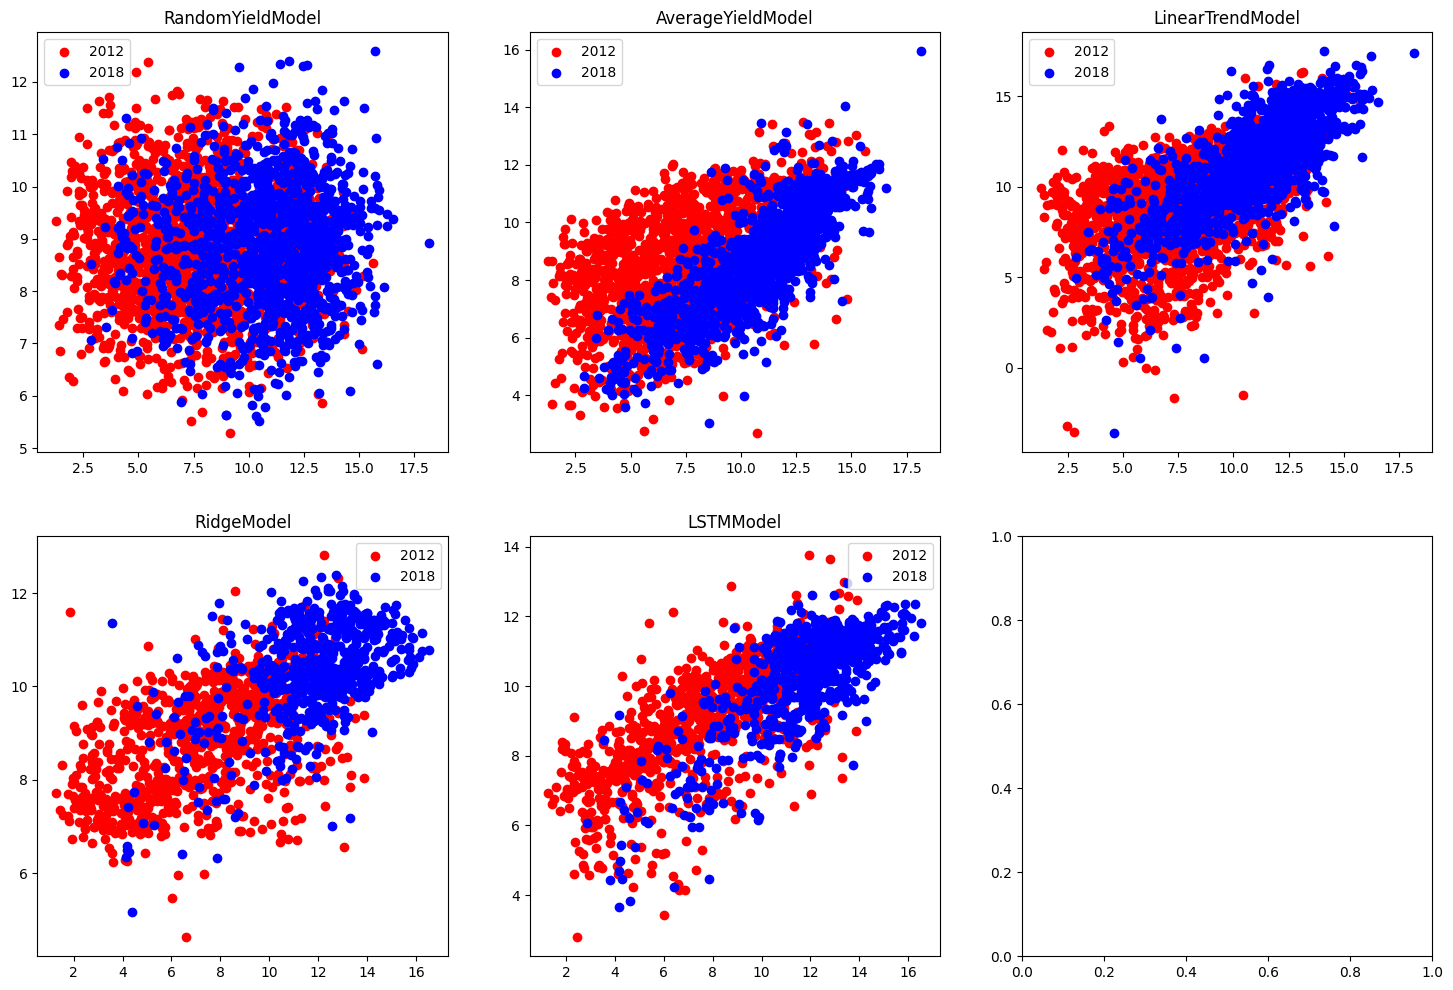

In [ ]:
sel_colors = ["red", "blue"]
scatterPlots(test_preds, test_years, sel_colors, "YIELD", "FYEAR")

## Scikit-learn KNN Model

### Model class

In [ ]:
import pickle

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, GroupKFold

from models.model import BaseModel


class KNNModel(BaseModel):
    def __init__(
        self, region_col="REGION", year_col="YEAR", label_col="YIELD", scaler=None
    ):
        self._region_col = region_col
        self._year_col = year_col
        self._label_col = label_col
        self._non_feature_cols = [self._region_col, self._year_col, self._label_col]

        self._knn = KNeighborsRegressor(n_neighbors=5, weights="distance")
        if scaler is None:
            self._scaler = StandardScaler()
        else:
            self._scaler = scaler

        self._pipeline = Pipeline(
            [("scaler", self._scaler), ("estimator", self._knn)]
        )
        self._best_est = None

    def fit(self, train_df):
        train_years = list(train_df[self._year_col].unique())
        # Hyperparameters to optimize
        param_grid = {"estimator__n_neighbors": [3, 5, 7, 9]}

        feature_cols = [c for c in train_df.columns if c not in self._non_feature_cols]
        X = train_df[feature_cols].values
        y = train_df[self._label_col].values

        # GroupKFold to split by years, n_splits = 5 for 5-fold
        # n_splits = number of years for leave-one-out
        group_kfold = GroupKFold(n_splits=len(train_years))
        groups = train_df[self._year_col].values
        cv = group_kfold.split(X, y, groups)

        # Search for optimal value of hyperparameters
        grid_search = GridSearchCV(self._pipeline, param_grid=param_grid, cv=cv)
        grid_search.fit(X, y)
        print("KNNModel Optimal Hyperparameters:")
        print(grid_search.best_params_)
        print("\n")

        self._best_est = grid_search.best_estimator_

    def predict(self, test_df):
        feature_cols = [c for c in test_df.columns if c not in self._non_feature_cols]
        X = test_df[feature_cols].values
        predictions_df = test_df[self._non_feature_cols].copy()
        predictions_df["PREDICTION"] = self._best_est.predict(X)

        return predictions_df

    def save(self, model_name):
        with open(model_name, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, model_name):
        with open(model_name, "rb") as f:
            saved_model = pickle.load(f)

        return saved_model

### Evaluation

In [ ]:
import os

from config import PATH_DATA_DIR
from config import PATH_OUTPUT_DIR
import pandas as pd


data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_features")
data_file = os.path.join(data_path, "grain_maize_US.csv")
data_df = pd.read_csv(data_file, header=0)
all_years = list(data_df["FYEAR"].unique())
test_years = [2012, 2018]
train_years = [yr for yr in all_years if yr not in test_years]
train_df = data_df[data_df["FYEAR"].isin(train_years)]
test_df = data_df[data_df["FYEAR"].isin(test_years)]
knn_model = KNNModel(region_col="COUNTY_ID", year_col="FYEAR")
knn_model.fit(train_df)

knn_preds = knn_model.predict(test_df)
print(knn_preds.head(5).to_string())

output_path = os.path.join(PATH_OUTPUT_DIR, "saved_models")
os.makedirs(output_path, exist_ok=True)

# Test saving and loading
knn_model.save(output_path + "/saved_knn_model.pkl")
saved_model = KNNModel.load(output_path + "/saved_knn_model.pkl")
knn_preds = saved_model.predict(test_df)
print("\n")
print("Predictions of saved model. Should match earlier output.")
print(knn_preds.head(5).to_string())
print("\n")

test_preds["KNNModel"] = knn_preds
evaluatePredictions(test_preds, "YIELD", "FYEAR")

KNNModel Optimal Hyperparameters:
{'estimator__n_neighbors': 9}


          COUNTY_ID  FYEAR   YIELD  PREDICTION
7170     AL_CALHOUN   2012   6.638    7.725365
7172     AL_CALHOUN   2018  10.504    8.484498
7173     AL_COLBERT   2012   6.886    7.917536
7177     AL_COLBERT   2018  10.330   10.033806
7178  AL_LAUDERDALE   2012   5.091    7.913398


Predictions of saved model. Should match earlier output.
          COUNTY_ID  FYEAR   YIELD  PREDICTION
7170     AL_CALHOUN   2012   6.638    7.725365
7172     AL_CALHOUN   2018  10.504    8.484498
7173     AL_COLBERT   2012   6.886    7.917536
7177     AL_COLBERT   2018  10.330   10.033806
7178  AL_LAUDERDALE   2012   5.091    7.913398




Predictions of  RandomYieldModel
    COUNTY_ID  FYEAR   YIELD  PREDICTION
0  AL_AUTAUGA   2018  11.137    7.779943
1   AL_DALLAS   2018   9.233    8.131938
2   AL_ELMORE   2018  11.466    9.047807
3    AL_PERRY   2018   9.765    8.530822
4  AL_BALDWIN   2018  10.222    9.255004


Predictions of  AverageYie

### Scatter plots

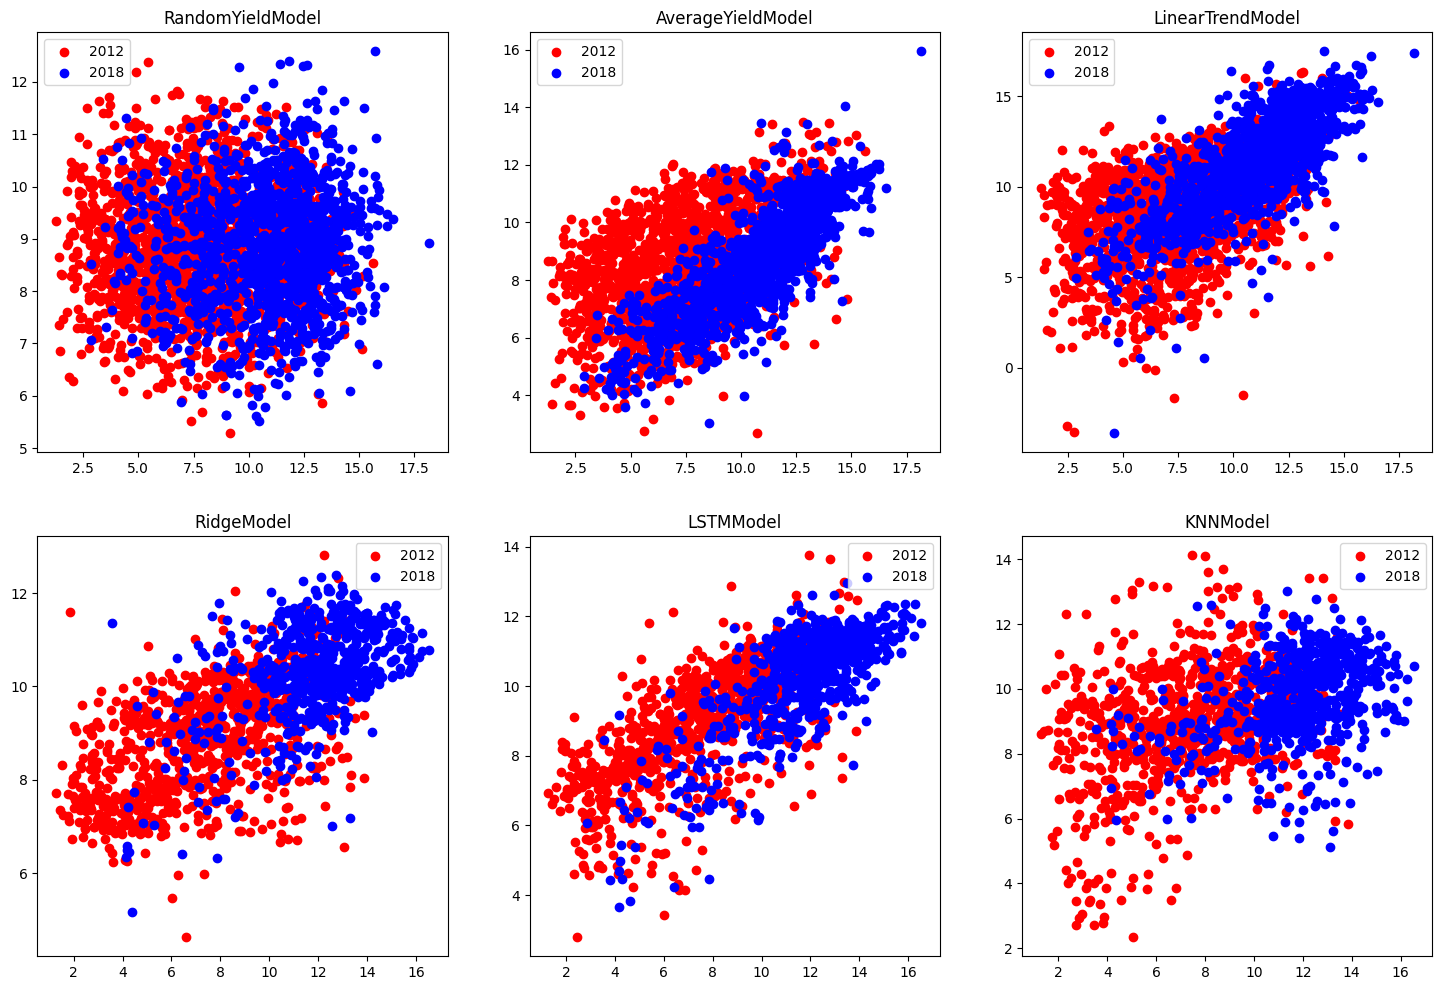

In [ ]:
scatterPlots(test_preds, test_years, sel_colors, "YIELD", "FYEAR")

## PyTorch LSTMModelv2 model

### Model class

In [ ]:
import logging
import random
import pandas as pd
import torch
from torch import nn

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from models.model import BaseModel
from datasets.torch_dataset import TorchDataset
from util.data import normalize_data
from config import LOGGER_NAME


class LSTMModelv2(BaseModel, nn.Module):
    def __init__(
        self,
        num_ts_inputs,
        num_trend_features,
        num_other_features,
        num_rnn_layers=1,
        rnn_hidden_size=64,
        num_outputs=1,
        *args,
        **kwargs
    ):
        super().__init__(*args, **kwargs)
        self._batch_norm1 = nn.BatchNorm1d(num_ts_inputs, dtype=torch.double)
        self._rnn = nn.LSTM(
            input_size=num_ts_inputs,
            hidden_size=rnn_hidden_size,
            num_layers=num_rnn_layers,
            batch_first=True,
            dtype=torch.double,
        )

        num_all_features = rnn_hidden_size + num_trend_features + num_other_features
        self._batch_norm2 = nn.BatchNorm1d(num_all_features, dtype=torch.double)
        self._fc1 = nn.Linear(num_all_features, 32, dtype=torch.double)
        self._batch_norm3 = nn.BatchNorm1d(num_features=32, dtype=torch.double)
        self._relu = nn.ReLU()
        self._dropout = nn.Dropout(p = 0.1)
        self._fc2 = nn.Linear(32, num_outputs, dtype=torch.double)
        self._max_epochs = 10
        self._logger = logging.getLogger(LOGGER_NAME)
        # self._norm_params = None
        # self._normalization = "standard"

    def fit(self, train_dataset, epochs=None):
        label_col = train_dataset.labelCol
        all_inputs = train_dataset.featureCols
        ts_inputs = train_dataset.timeSeriesCols
        other_features = [c for c in all_inputs if (c not in ts_inputs)]
        batch_size = 16

        # self._norm_params = train_dataset.get_normalization_params(normalization=self._normalization)
        if epochs is None:
            epochs = self._max_epochs

        loss = nn.MSELoss()

        # Hyperparameter optimization
        save_model_path = os.path.join(
            PATH_OUTPUT_DIR, "saved_models", "saved_lstm_model"
        )
        torch.save(self.state_dict(), save_model_path)
        hparam_grid = {"lr": [0.0001, 0.00005], "weight_decay": [0.0001, 0.00001]}
        optimal_hparams = self._optimize_hyperparameters(
            train_dataset,
            label_col,
            ts_inputs,
            other_features,
            hparam_grid,
            loss,
            batch_size,
            epochs,
            save_model_path,
        )
        sel_lr = optimal_hparams["lr"]
        sel_wt_decay = optimal_hparams["weight_decay"]

        # retrain with optimal hyperparameters
        self.load_state_dict(torch.load(save_model_path))
        self.train()
        torch_dataset = TorchDataset(train_dataset)
        data_loader = torch.utils.data.DataLoader(
            torch_dataset,
            collate_fn=torch_dataset.collate_fn,
            shuffle=True,
            batch_size=batch_size,
        )
        trainer = torch.optim.Adam(
            self.parameters(), lr=sel_lr, weight_decay=sel_wt_decay
        )
        for epoch in range(epochs):
            train_metrics = self._train_epoch(
                data_loader, label_col, ts_inputs, other_features, loss, trainer, epoch
            )
            self._logger.debug(
                "LSTMModel epoch:%d, loss:%f, NRMSE:%f",
                epoch,
                train_metrics["loss"],
                train_metrics["train NRMSE"],
            )

    def _train_epoch(
        self, train_loader, label_col, ts_inputs, other_features, loss, trainer, epoch
    ):
        epoch_loss = 0
        num_elems = 0
        y_all = None
        y_hat_all = None
        for batch in train_loader:
            # batch = normalize_data(batch, self._norm_params, normalization=self._normalization)
            y = torch.unsqueeze(batch[label_col], 1)
            X_ts = torch.cat([torch.unsqueeze(batch[c], 1) for c in ts_inputs], dim=1)
            X_rest = torch.cat([batch[c] for c in other_features])
            if len(X_rest.shape) == 1:
                X_rest = torch.unsqueeze(X_rest, 1)

            y_hat = self(X_ts, X_rest)
            l = loss(y_hat, y)
            trainer.zero_grad()
            l.backward()
            trainer.step()
            epoch_loss += float(l)
            num_elems += y.size().numel()

            if y_all is None:
                y_all = y
                y_hat_all = y_hat
            else:
                y_all = torch.cat([y_all, y], dim=0)
                y_hat_all = torch.cat([y_hat_all, y_hat], dim=0)

        train_nrmse = (
            100 * torch.sqrt(torch.mean((y_hat_all - y_all) ** 2)) / torch.mean(y_all)
        )

        return {"loss": epoch_loss / num_elems, "train NRMSE": train_nrmse.item()}

    def _optimize_hyperparameters(
        self,
        train_dataset,
        label_col,
        ts_inputs,
        other_features,
        hparam_grid,
        loss,
        batch_size,
        epochs,
        save_model_path,
    ):
        train_years = train_dataset.years
        # year_splits = [(list(range(2000, 2012)), list(range(2013, 2018)))]
        year_splits = self._get_validation_splits(
            train_years, num_folds=1, num_valid_years=5
        )
        self._logger.debug("Year splits for hyperparameter optimization")
        for i, (train_years2, valid_years) in enumerate(year_splits):
            self._logger.debug("Split %d Training years: %s", i, train_years2)
            self._logger.debug("Split %d Validation years: %s", i, valid_years)

        optimal_hparams = {}
        for param in hparam_grid:
            optimal_hparams[param] = None

        lowest_nrmse = None
        for lr in hparam_grid["lr"]:
            for wt_decay in hparam_grid["weight_decay"]:
                cv_nrmses = np.zeros(len(year_splits))
                for i, (train_years2, valid_years) in enumerate(year_splits):
                    train_dataset2, valid_dataset = train_dataset.split_on_years(
                        (train_years2, valid_years)
                    )
                    torch_dataset = TorchDataset(train_dataset2)
                    data_loader = torch.utils.data.DataLoader(
                        torch_dataset,
                        collate_fn=torch_dataset.collate_fn,
                        shuffle=True,
                        batch_size=batch_size,
                    )
                    trainer = torch.optim.Adam(
                        self.parameters(), lr=lr, weight_decay=wt_decay
                    )
                    self.load_state_dict(torch.load(save_model_path))
                    self.train()
                    valid_nrmse = None
                    for epoch in range(epochs):
                        metrics = self._train_epoch(
                            data_loader,
                            label_col,
                            ts_inputs,
                            other_features,
                            loss,
                            trainer,
                            epoch,
                        )
                        predictions_df = self.predict(valid_dataset)
                        y_true = predictions_df[label_col].values
                        y_pred = predictions_df["PREDICTION"].values
                        valid_nrmse = normalized_rmse(y_true, y_pred)

                    # Using valid_nrmse from the last epoch
                    cv_nrmses[i] = valid_nrmse

                avg_nrmse = np.mean(cv_nrmses)
                self._logger.debug(
                    "LSTMModel lr:%f, wt_decay:%f, avg NRMSE:%f",
                    lr,
                    wt_decay,
                    avg_nrmse,
                )

                if (lowest_nrmse is None) or (avg_nrmse < lowest_nrmse):
                    lowest_nrmse = avg_nrmse
                    optimal_hparams["lr"] = lr
                    optimal_hparams["weight_decay"] = wt_decay

        self._logger.debug(
            "LSTMModel Optimal lr:%f, wt_decay:%f, avg NRMSE %f",
            optimal_hparams["lr"],
            optimal_hparams["weight_decay"],
            lowest_nrmse,
        )

        return optimal_hparams

    def _get_validation_splits(self, all_years, num_folds=1, num_valid_years=5):
        year_splits = []
        assert len(all_years) >= (num_folds * num_valid_years)
        if num_folds > 1:
            random.shuffle(all_years)

        for i in range(num_folds):
            valid_years = all_years[i * num_valid_years : (i + 1) * num_valid_years]
            train_years = [yr for yr in all_years if yr not in valid_years]
            year_splits.append((train_years, valid_years))

        return year_splits

    def predict(self, test_dataset):
        self.eval()
        label_col = test_dataset.labelCol
        index_cols = test_dataset.indexCols
        all_inputs = test_dataset.featureCols
        ts_inputs = test_dataset.timeSeriesCols
        other_features = [c for c in all_inputs if (c not in ts_inputs)]

        torch_dataset = TorchDataset(test_dataset)
        data_loader = torch.utils.data.DataLoader(
            torch_dataset,
            collate_fn=torch_dataset.collate_fn,
            shuffle=False,
            batch_size=16,
        )

        predictions_df = None
        data_cols = index_cols + [label_col, "PREDICTION"]
        for batch in data_loader:
            # batch = normalize_data(batch, self._norm_params, normalization=self._normalization)
            y = torch.unsqueeze(batch[label_col], 1)
            X_ts = torch.cat([torch.unsqueeze(batch[c], 1) for c in ts_inputs], dim=1)
            X_rest = torch.cat([batch[c] for c in other_features])
            if len(X_rest.shape) == 1:
                X_rest = torch.unsqueeze(X_rest, 1)

            y_hat = self(X_ts, X_rest)
            data = []
            num_items = y.shape[0]
            for i in range(num_items):
                data_item = []
                for c in index_cols:
                    data_item.append(batch[c][i])

                data_item += [y[i].item(), y_hat[i].item()]
                data.append(data_item)

            batch_preds = pd.DataFrame(data, columns=data_cols)
            if predictions_df is None:
                predictions_df = batch_preds
            else:
                predictions_df = pd.concat([predictions_df, batch_preds], axis=0)

        return predictions_df

    def forward(self, X_ts, X_rest):
        X_ts_norm = self._batch_norm1(X_ts)
        # self._rnn expects (batch, sequence, input variables)
        _, ts_state = self._rnn(X_ts_norm.permute(0, 2, 1))
        ts_h_out = ts_state[0][self._rnn.num_layers - 1].view(-1, self._rnn.hidden_size)

        all_inputs = self._batch_norm2(torch.cat([ts_h_out, X_rest], 1))
        output1 = self._dropout(self._relu(self._fc1(all_inputs)))

        return self._fc2(self._batch_norm3(output1))

    def save(self, model_name):
        torch.save(self, model_name)

    @classmethod
    def load(cls, model_name):
        return torch.load(model_name)

### Evaluation

In [ ]:
data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_features")
data_file = os.path.join(data_path, "grain_maize_US.csv")
data_df = pd.read_csv(data_file, header=0)
all_years = list(data_df["FYEAR"].unique())
test_years = [2012, 2018]
train_years = [yr for yr in all_years if yr not in test_years]
train_df = data_df[data_df["FYEAR"].isin(train_years)]
test_df = data_df[data_df["FYEAR"].isin(test_years)]
lstm_v2_model = LSTMModelv2(len(ts_inputs), 0, len(other_features))
lstm_v2_model.fit(train_dataset, epochs=5)
lstm_v2_preds = lstm_v2_model.predict(test_dataset)
test_preds["LSTMModelv2"] = lstm_v2_preds
evaluatePredictions(test_preds, "YIELD", "FYEAR")

2024-01-18 15:19:15,447 agml_cyf     DEBUG    Year splits for hyperparameter optimization
DEBUG:agml_cyf:Year splits for hyperparameter optimization
2024-01-18 15:19:15,452 agml_cyf     DEBUG    Split 0 Training years: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015]
DEBUG:agml_cyf:Split 0 Training years: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2013, 2014, 2015]
2024-01-18 15:19:15,457 agml_cyf     DEBUG    Split 0 Validation years: [2016, 2017, 2000, 2001, 2002]
DEBUG:agml_cyf:Split 0 Validation years: [2016, 2017, 2000, 2001, 2002]
2024-01-18 15:23:14,003 agml_cyf     DEBUG    LSTMModel lr:0.000100, wt_decay:0.000100, avg NRMSE:17.934637
DEBUG:agml_cyf:LSTMModel lr:0.000100, wt_decay:0.000100, avg NRMSE:17.934637
2024-01-18 15:27:22,215 agml_cyf     DEBUG    LSTMModel lr:0.000100, wt_decay:0.000010, avg NRMSE:25.988156
DEBUG:agml_cyf:LSTMModel lr:0.000100, wt_decay:0.000010, avg NRMSE:25.988156
2024-01-18 15:30:57,419 agml_cyf     DEBUG    LSTMM



Predictions of  RandomYieldModel
    COUNTY_ID  FYEAR   YIELD  PREDICTION
0  AL_AUTAUGA   2018  11.137    7.779943
1   AL_DALLAS   2018   9.233    8.131938
2   AL_ELMORE   2018  11.466    9.047807
3    AL_PERRY   2018   9.765    8.530822
4  AL_BALDWIN   2018  10.222    9.255004


Predictions of  AverageYieldModel
    COUNTY_ID  FYEAR   YIELD  PREDICTION
0  AL_AUTAUGA   2018  11.137    5.139529
1   AL_DALLAS   2018   9.233    6.008579
2   AL_DALLAS   2012   7.814    6.008579
3   AL_ELMORE   2018  11.466    6.654050
4   AL_ELMORE   2012  14.291    6.654050


Predictions of  LinearTrendModel
      COUNTY_ID  FYEAR   YIELD  PREDICTION
0    AL_AUTAUGA   2018  11.137   11.531525
210  AL_BALDWIN   2012   8.292    7.806919
4    AL_BALDWIN   2018  10.222   10.706000
216   AL_BLOUNT   2012   4.708    7.513204
211   AL_BUTLER   2012   8.218    6.125096


Predictions of  RidgeModel
          COUNTY_ID  FYEAR   YIELD  PREDICTION
7170     AL_CALHOUN   2012   6.638    8.061749
7172     AL_CALHOUN  

### Scatter plots

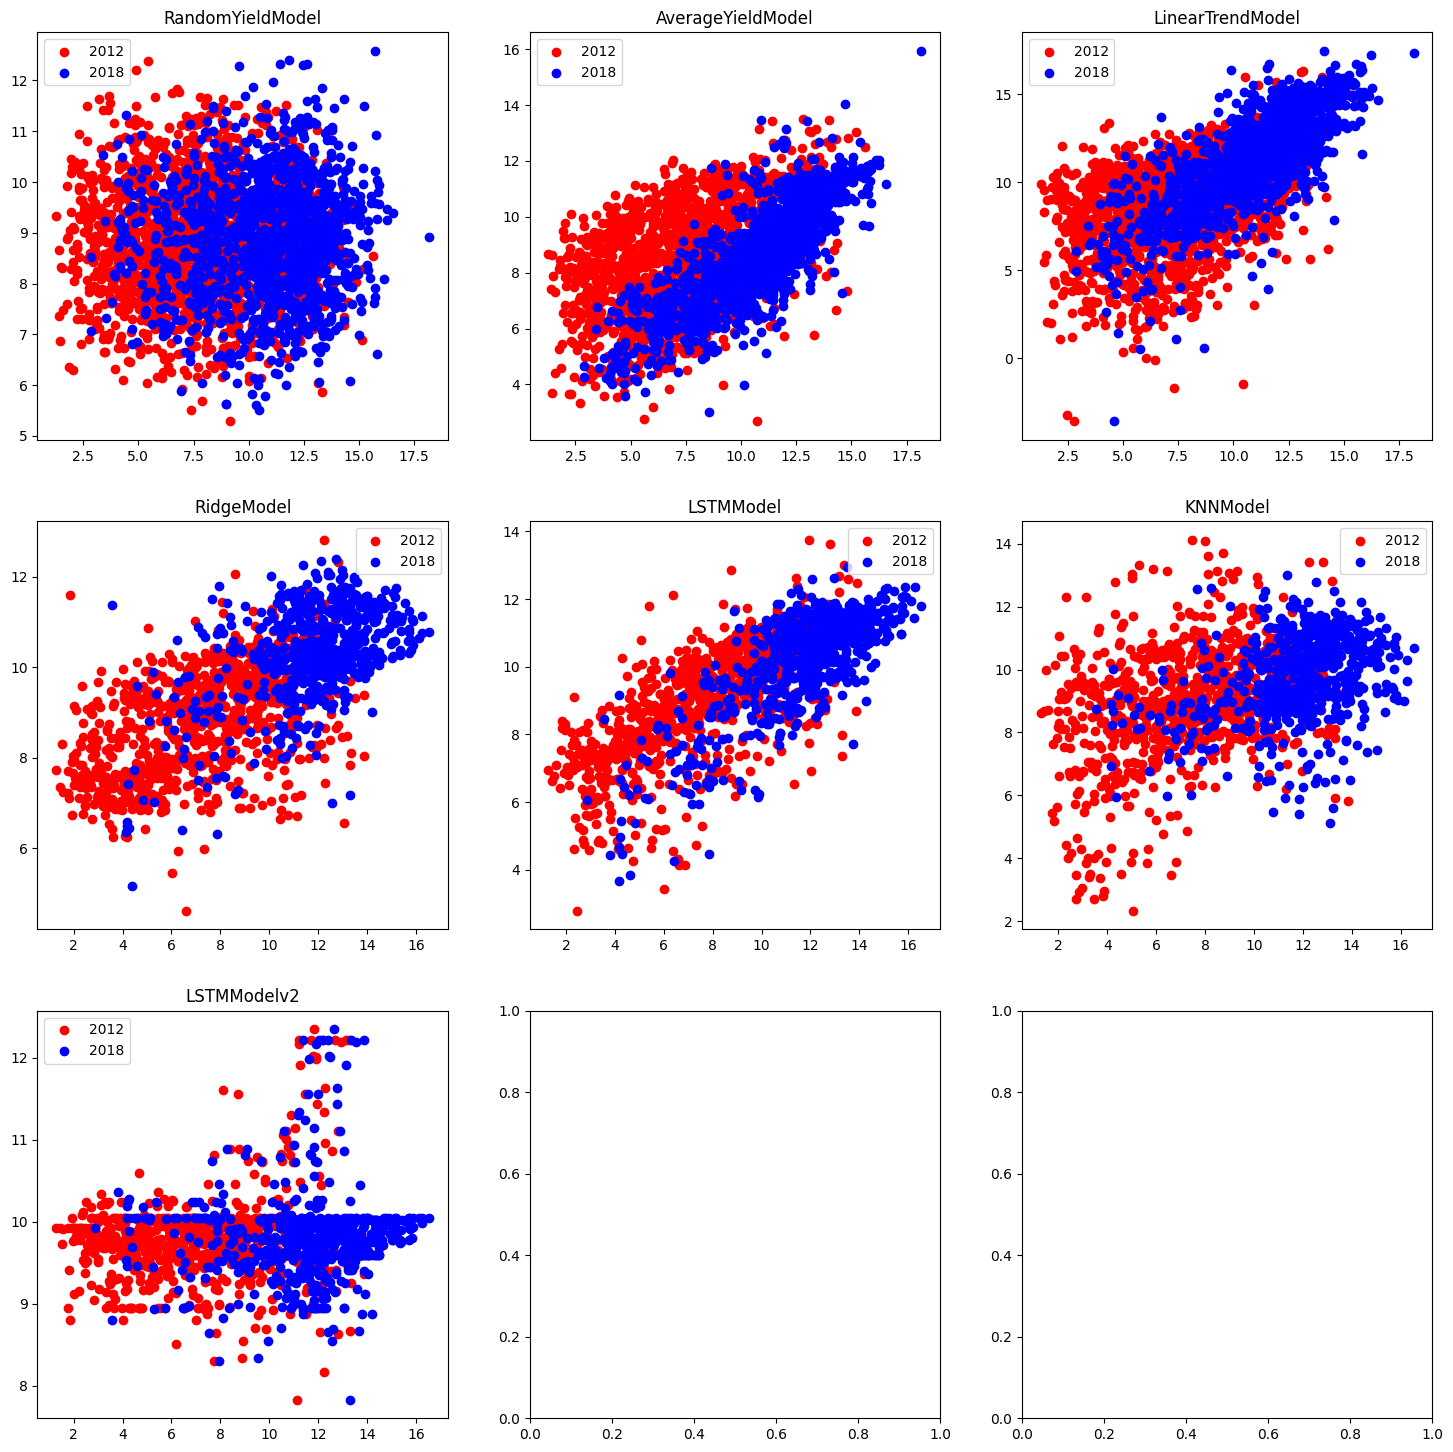

In [ ]:
scatterPlots(test_preds, test_years, sel_colors, "YIELD", "FYEAR")

## RidgeModel using yield trend features

### Create trend features

In [ ]:
from util.data import trend_features

data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_data")
yield_csv = os.path.join(data_path, "YIELD_COUNTY_US.csv")
yield_df = pd.read_csv(yield_csv, header=0)
all_years = list(yield_df["FYEAR"].unique())
test_years = [2012, 2018]
train_years = [yr for yr in all_years if yr not in test_years]
train_df = yield_df[yield_df["FYEAR"].isin(train_years)]
test_df = yield_df[yield_df["FYEAR"].isin(test_years)]

# For training, we can only use training data to create yield trend features
train_trend = trend_features(train_df, "COUNTY_ID", "FYEAR", "YIELD", 5)
train_trend = train_trend.dropna(axis=0)
train_trend = train_trend.drop(columns=["YIELD"] + ["FYEAR-" + str(i) for i in range(1, 6)])

# For test data, we can combine train_df and test_df to get trend features

combined_df = pd.concat([train_df, test_df], axis=0)
test_trend = trend_features(combined_df, "COUNTY_ID", "FYEAR", "YIELD", 5)
test_trend = test_trend.dropna(axis=0)
test_trend = test_trend[test_trend["FYEAR"].isin(test_years)]
test_trend = test_trend.drop(columns=["YIELD"] + ["FYEAR-" + str(i) for i in range(1, 6)])

print("\n")
print(train_trend.head(5).to_string())
print("\n")
print(test_trend.head(5).to_string())



      COUNTY_ID  FYEAR  YIELD-5  YIELD-4  YIELD-3  YIELD-2  YIELD-1
663  AL_AUTAUGA   1999    5.380    3.363    2.556    5.044    2.219
621  AL_AUTAUGA   2000    3.363    2.556    5.044    2.219    5.111
592  AL_AUTAUGA   2001    2.556    5.044    2.219    5.111    2.085
538  AL_AUTAUGA   2002    5.044    2.219    5.111    2.085    4.775
491  AL_AUTAUGA   2003    2.219    5.111    2.085    4.775    3.497


      COUNTY_ID  FYEAR  YIELD-5  YIELD-4  YIELD-3  YIELD-2  YIELD-1
0    AL_AUTAUGA   2018    4.438    2.690    7.471    6.678   11.486
210  AL_BALDWIN   2012    5.985    7.061    8.339   10.888    4.432
4    AL_BALDWIN   2018   10.491    9.341    9.899   10.283   10.894
216   AL_BLOUNT   2012    6.322    8.608    9.348    7.398    7.364
211   AL_BUTLER   2012    1.143    4.438    2.690   11.971    4.116


### Add trend features

In [ ]:
data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_features")
data_file = os.path.join(data_path, "grain_maize_US.csv")
data_df = pd.read_csv(data_file, header=0)
all_years = list(data_df["FYEAR"].unique())
test_years = [2012, 2018]
train_years = [yr for yr in all_years if yr not in test_years]
train_df = data_df[data_df["FYEAR"].isin(train_years)]
test_df = data_df[data_df["FYEAR"].isin(test_years)]

train_df = train_df.merge(train_trend, on=["COUNTY_ID", "FYEAR"])
test_df = test_df.merge(test_trend, on=["COUNTY_ID", "FYEAR"])

print("\n")
print(train_df.head(5).to_string())
print("\n")
print(train_df.head(5).to_string())



    COUNTY_ID  FYEAR     SM_WHC  avgTAVGp0  avgCWBp0  avgPRECp0  avgTAVGp1  avgPRECp1  avgTAVGp2  avgCWBp2  avgTAVGp3  avgPRECp3  avgCWBp4  Z-TAVGp1  Z-TMINp1  Z-PRECp1  Z+TAVGp1  Z+TMINp1  Z+PRECp1  Z-TAVGp3  Z-CWBp3  Z-PRECp3  Z-TMAXp3  Z+TAVGp3  Z+CWBp3  Z+PRECp3  Z+TMAXp3  avgFAPARp2  YIELD  YIELD-5  YIELD-4  YIELD-3  YIELD-2  YIELD-1
0  AL_CALHOUN   2002  11.104716      13.81     -3.45      25.58      21.22      21.48      24.45   -157.73      26.00      58.03   -113.29       0.0       0.0      0.89      4.31      4.37      0.00      0.27     0.00      0.12      2.08      0.65     1.57      5.32      0.01        0.68  6.456    7.976    3.900    6.120    6.052    5.649
1  AL_CALHOUN   2004  11.104716      13.19      8.54      27.84      22.38      31.47      24.75   -100.58      25.04      39.88   -102.58       0.0       0.0      0.97      5.03      5.68      1.41      1.12     0.00      0.07      0.65      0.20     1.79      2.62      0.08        0.77  9.684    6.120    6.052   

### Train and Evaluate

In [ ]:
ridge_trend_model = RidgeModel(region_col="COUNTY_ID", year_col="FYEAR")
ridge_trend_model.fit(train_df)

ridge_trend_preds = ridge_trend_model.predict(test_df)
print("RidgeModel without trend features (NRMSE)",
      normalized_rmse(ridge_preds["YIELD"].values,
                      ridge_preds["PREDICTION"].values))
print("RidgeModel with trend features (NRMSE)",
      normalized_rmse(ridge_trend_preds["YIELD"].values,
                      ridge_trend_preds["PREDICTION"].values))

RidgeModel Optimal Hyperparameters:
{'estimator__alpha': 10.0}


RidgeModel without trend features (NRMSE) 29.70243580564072
RidgeModel with trend features (NRMSE) 29.347998296949523


## Option 1: Build your own model using `county_data`

### Model class

In [ ]:
import pickle

from models.model import BaseModel

##########################
# Update the class below #
##########################

class YourModel(BaseModel):
    def __init__(self):
        pass

    def fit(self, train_dataset, epochs=None, **fit_params):
        pass

    def predict(self, test_dataset):
        pass

    def save(self, model_name):
        with open(model_name, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, model_name):
        with open(model_name, "rb") as f:
            saved_model = pickle.load(f)

        return saved_model

### Train your model and evaluate on the test set

In [ ]:
from config import PATH_DATA_DIR

data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_data")
data_sources = {
    "YIELD": {
        "filename": "YIELD_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID", "FYEAR"],
        "sel_cols": ["YIELD"],
    },
    "METEO": {
        "filename": "METEO_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID", "FYEAR", "DEKAD"],
        "sel_cols": ["TMAX", "TMIN", "TAVG", "PREC", "ET0", "RAD"],
    },
    "SOIL": {
        "filename": "SOIL_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID"],
        "sel_cols": ["SM_WHC"],
    },
    "REMOTE_SENSING": {
        "filename": "REMOTE_SENSING_COUNTY_US.csv",
        "index_cols": ["COUNTY_ID", "FYEAR", "DEKAD"],
        "sel_cols": ["FAPAR"],
    },
}

train_years = [y for y in range(2000, 2012)]
test_years = [y for y in range(2012, 2019)]
dataset = CropYieldDataset(
    data_sources, spatial_id_col="COUNTY_ID", year_col="FYEAR", data_path=data_path,
    lead_time=6
)

# Use the static train_test_split()
train_dataset, test_dataset = dataset.split_on_years((train_years, test_years))

#########################
# Update the code below #
#########################

your_model = YourModel()
your_model.fit(train_dataset)
predictions_df = your_model.predict(test_dataset)
predictions_df.to_csv("<YourModel>_predictions.csv", index=False)

## Option 2: Build your own model using `county_features`

### Model class

In [ ]:
import pickle

from models.model import BaseModel

##########################
# Update the class below #
##########################

class YourModel(BaseModel):
    def __init__(self):
        pass

    def fit(self, train_df, **fit_params):
        pass

    def predict(self, test_df):
        pass

    def save(self, model_name):
        with open(model_name, "wb") as f:
            pickle.dump(self, f)

    @classmethod
    def load(cls, model_name):
        with open(model_name, "rb") as f:
            saved_model = pickle.load(f)

        return saved_model

### Train your model and evaluate on the test set

In [ ]:
data_path = os.path.join(PATH_DATA_DIR, "data_US", "county_features")
data_file = os.path.join(data_path, "grain_maize_US.csv")
data_df = pd.read_csv(data_file, header=0)
all_years = list(data_df["FYEAR"].unique())
test_years = [2012, 2018]
train_years = [yr for yr in all_years if yr not in test_years]
train_df = data_df[data_df["FYEAR"].isin(train_years)]
test_df = data_df[data_df["FYEAR"].isin(test_years)]

#########################
# Update the code below #
#########################
your_model = YourModel()
your_model.fit(train_dataset)
predictions_df = your_model.predict(test_dataset)
predictions_df.to_csv("<YourModel>_predictions.csv", index=False)

## Submit to Comet

Run the code below to submit your model class and predictions.

In [ ]:
# change to your model predictions
your_model_preds = None
metrics = getMetrics(your_model_preds, test_years, "YIELD", "FYEAR")
# change the name of experiment
experiment.set_name("<Your Name>")
experiment.log_metrics(metrics)
experiment.end()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/drpaudel/agml-workshop/340755d47c884c2fad9d7c742737fa77

COMET WARNING: Couldn't retrieve Google Colab notebook content
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/drpaudel/agml-worksh